Target Thickness
================

Target thickness of the new foil from Anna Simon in the 55-60 $\mu$g/cm$^2$ range, but that was from a rough check. We need to find the energy loss through the target for each alpha peak (241Am/146Gd), using the `calibration_source.h5` file for energy calibration and initial values and `calibration_target.h5` to determine the properties of our target.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.signal import find_peaks_cwt
import statsmodels.api as sm

import pyne
import sap
pyne.__version__, sap.__version__

('0.5.1', '2017-04-21')

In [2]:
source = pyne.CHNData('../data_np/calibration_source')
source.load_data()
source_det = source.adc
source_det.energies = source_det.bins[:-1]

target = pyne.CHNData('../data_np/calibration_target')
target.load_data()
target_det = target.adc
target_det.energies = target_det.bins[:-1]

reading from ../data_np/calibration_source...
reading from ../data_np/calibration_target...


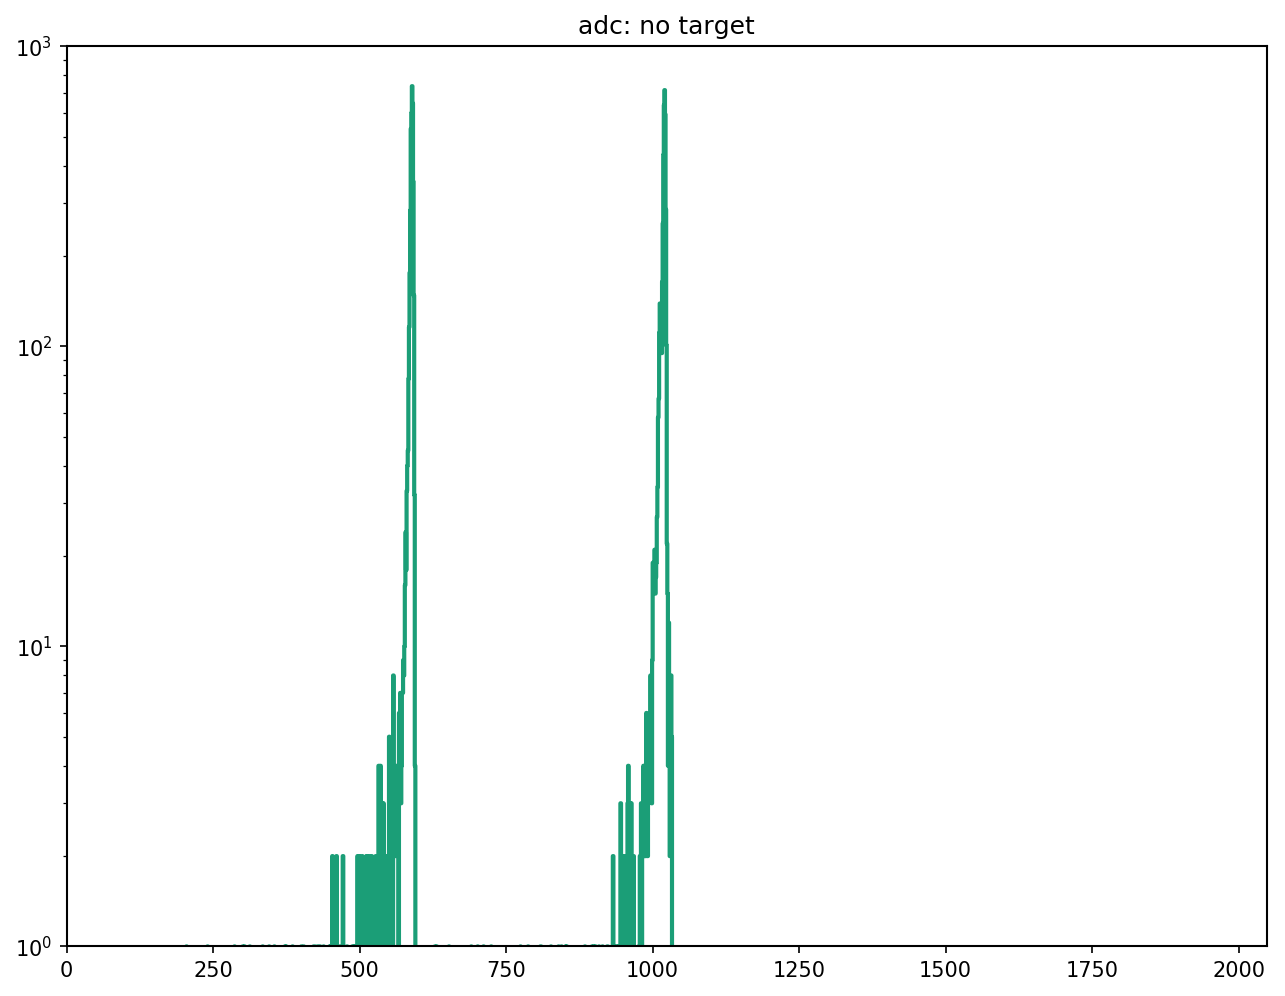

In [3]:
display = sap.Display(None)
source_det.name = 'adc: no target'
display.single_plot(source_det, xlim=(0, 2048))
plt.show()

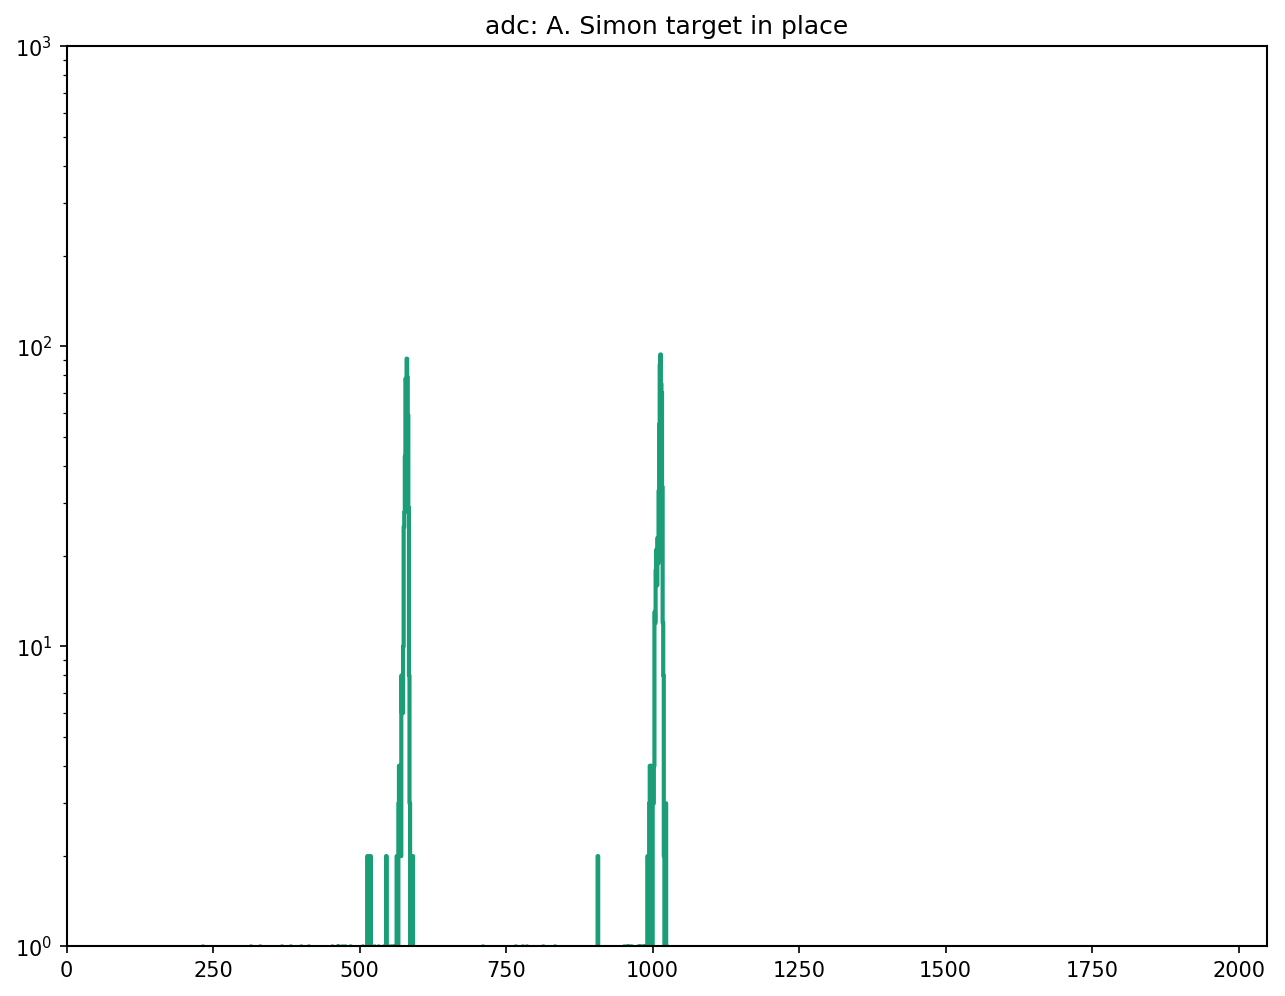

In [4]:
target_det.name = 'adc: A. Simon target in place'
display.single_plot(target_det, xlim=(0, 2048))
plt.show()

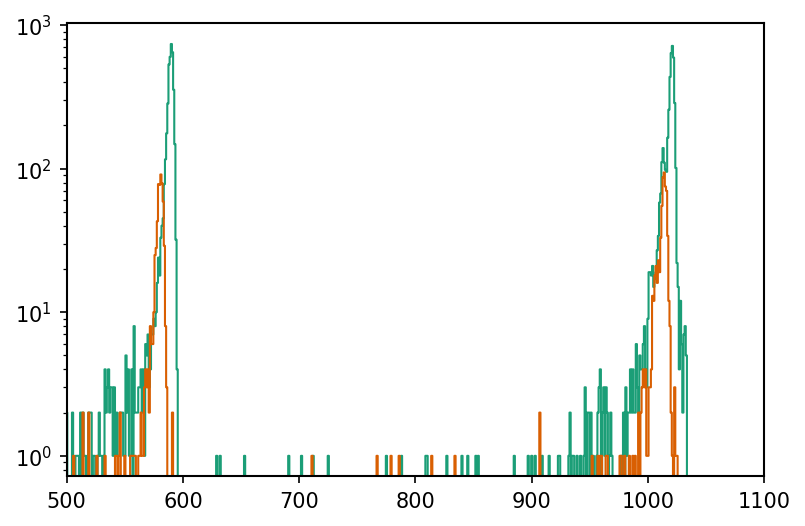

In [5]:
x = source_det.bins[:-1]
plt.semilogy(x, source_det.counts, lw=1, drawstyle='steps-mid', nonposy='clip')
plt.semilogy(x, target_det.counts, lw=1, drawstyle='steps-mid', nonposy='clip')
plt.xlim((500, 1100))
plt.show()

Calibration
-----------

Using our source spectra, we need to find and fit the peaks. Since we can see the second 13.1% peak from 241Am, we'll use it as a third point for us.

In [6]:
peaks = find_peaks_cwt(source_det.counts, np.linspace(50, 75, 25))
peaks, source_det.counts[peaks]

([589, 1019], array([600, 435]))

In [7]:
def gaus(x, A, sig, mu):
    return A * np.exp(-(x - mu)**2 / (2 * sig**2))

def lorentzian(x, I, gamma, x0):
    return I * gamma**2 / ((x - x0)**2 + gamma**2)

def gd_peak(x, A, sig, mu, gamma):
    return np.where(x > mu, gaus(x, A, sig, mu), lorentzian(x, A, gamma, mu))

def am_peak(x, A0, sig0, mu0, gamma, A1, sig1, mu1):
    return gd_peak(x, A0, sig0, mu0, gamma) + gaus(x, A1, sig1, mu1)

In [8]:
p_gd = [700, 2, peaks[0] + 1, 2]
p_am = [700, 2, peaks[1] + 1, 2, 100, peaks[1] - 10, 2]  # add on our side peak to try it

par_gd, _ = curve_fit(gd_peak, x[500:650], source_det.counts[500:650], p0=p_gd)
par_am, _ = curve_fit(am_peak, x[950:1050], source_det.counts[950:1050], p0=p_am)

[ 751.70102557    1.71110628  589.92310366    2.2910484 ]


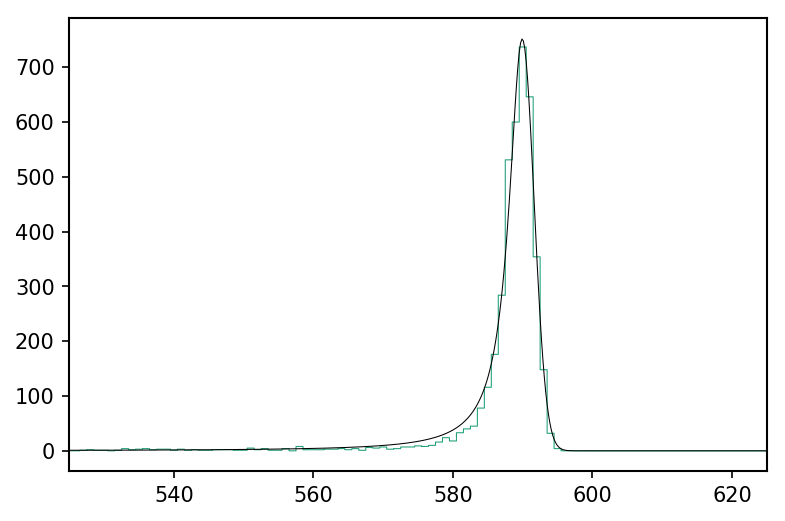

[  737.5937083      1.5819506   1020.86460807     2.12850824    85.25457298
    -1.28716798  1012.5679863 ]


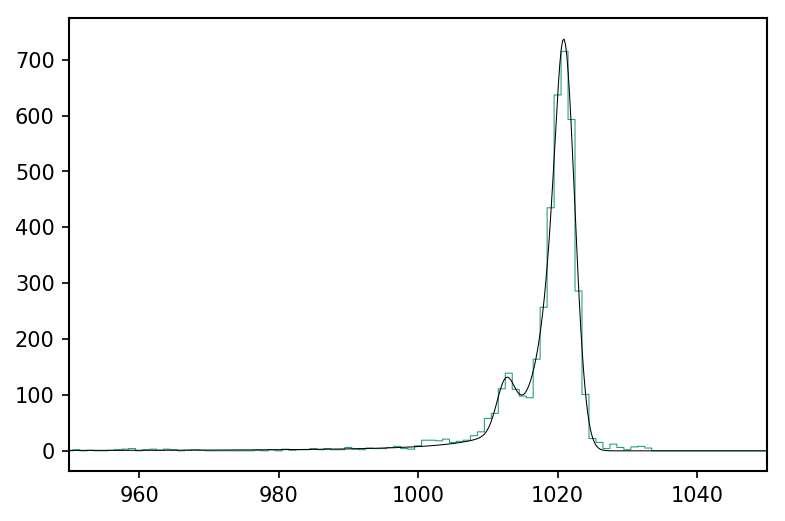

In [9]:
print(par_gd)
x_smooth_1 = np.linspace(500, 700, 1000)
plt.plot(x, source_det.counts, lw=0.5, drawstyle='steps-mid')
plt.plot(x_smooth_1, gd_peak(x_smooth_1, *par_gd), 'k-', lw=0.5)
plt.xlim((525, 625))
plt.show()

print(par_am)
x_smooth_2 = np.linspace(900, 1100, 1000)
plt.plot(x, source_det.counts, lw=0.5, drawstyle='steps-mid')
plt.plot(x_smooth_2, am_peak(x_smooth_2, *par_am), 'k-', lw=0.5)
plt.xlim((950, 1050))
plt.show()

Our peak values are 589.92310366, 1012.5679863, and 1020.86460807, corresponding to energies 3182.69, 5442.8, and 5485.56 keV. We can fit these values using a straight line to get our bins-to-energy calibration.

In [10]:
calibration_energies = [3182.69, 5442.8, 5485.56]  # 148Gd/241Am mixed source
peak_centers = [589.92310366, 1012.5679863, 1020.86460807]

peak_centers = sm.add_constant(peak_centers)
result = sm.OLS(calibration_energies, peak_centers).fit()
result.params

array([ 29.21097221,   5.34560262])

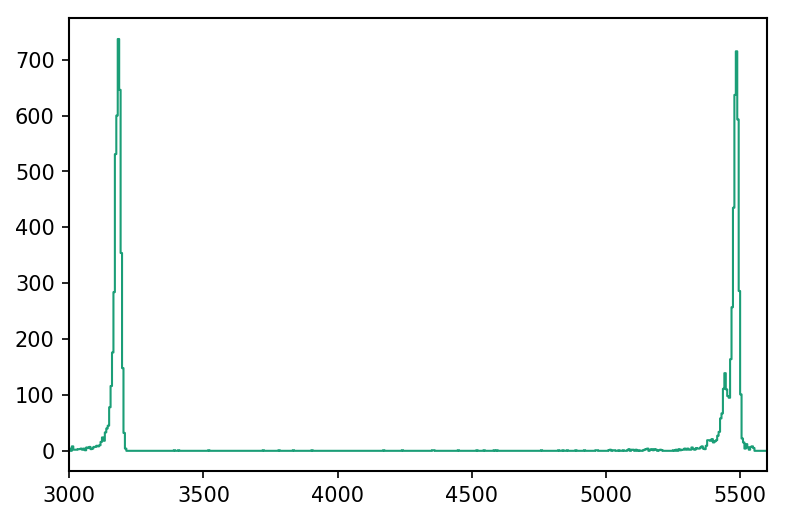

In [11]:
energy = result.predict(sm.add_constant(x))

plt.plot(energy, source_det.counts, lw=1, drawstyle='steps-mid')
plt.xlim((3000, 5600))
plt.show()

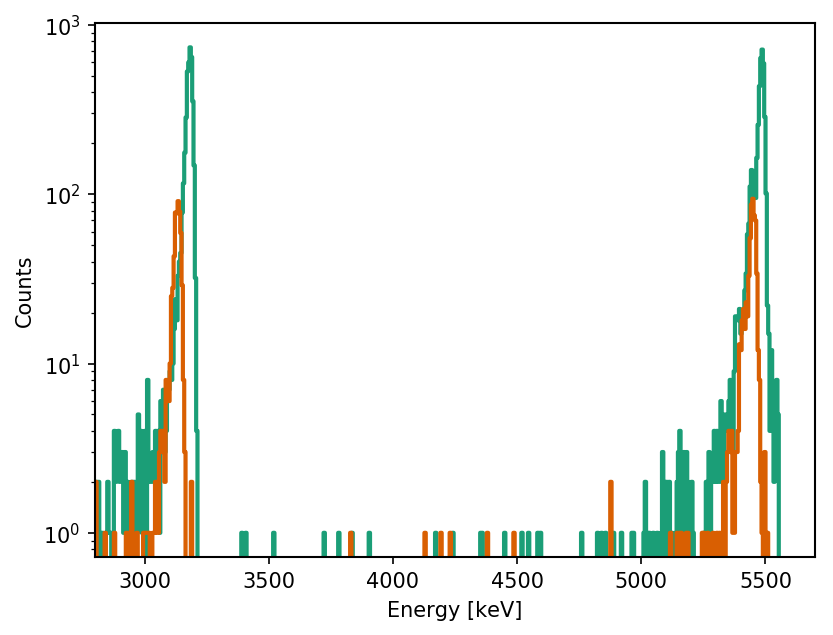

In [12]:
fig = plt.figure(figsize=(6, 4.45))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.semilogy(energy, source_det.counts, lw=2, drawstyle='steps-mid', nonposy='clip')
ax.semilogy(energy, target_det.counts, lw=2, drawstyle='steps-mid', nonposy='clip')
ax.set_xlim((2800, 5700))
ax.set_xlabel('Energy [keV]')
ax.set_ylabel('Counts')
plt.show()

In [37]:
pars, _ = curve_fit(gd_peak, energy[500:650], source_det.counts[500:650],
                    p0=[700, 15, 3000, 2])
print(pars)
sigma = abs(pars[1])
fwhm = 2.35 * sigma
print(sigma, fwhm)

[  751.70019785    -9.14688766  3182.70548028    12.24709096]
9.14688765836 21.4951859972


In [39]:
pars, _ = curve_fit(am_peak, energy[950:1050], source_det.counts[950:1050],
                    p0=[700, 15, 5500, 2, 100, 5400, 2])
print(pars)
sigma = abs(pars[1])
fwhm = 2.35 * sigma
print(sigma, fwhm)

[  737.5939598     -8.45648384  5486.34748312    11.3781316     85.25392827
     6.88083414  5441.99724297]
8.45648384074 19.8727370257


In [41]:
counts = source_det.counts[500:650]
half_max = counts.max() / 2
print(half_max)

for i, value in enumerate(counts):
    if value > half_max:
        left = i + 500
        break
# right
for i, value in enumerate(counts[::-1]):
    if value > half_max:
        right = 650 - i
        break
widths = [energy[right] - energy[left],
          energy[right - 1] - energy[left - 1],
          energy[right + 1] - energy[left - 1],
          energy[right - 1] - energy[left + 1],
          energy[right + 1] - energy[left + 1]]
widths = np.array(widths)
print(widths.mean(), widths.std(ddof=1))

368.5
21.3824104659 7.55982371929


In [42]:
widths

array([ 21.38241047,  21.38241047,  32.0736157 ,  10.69120523,  21.38241047])

Energy Loss
-----------

Since we have our energy calibration, we can use it with our `calibration_target` data to see how far our peaks have shifted in energy when our target is in place. We will refit our three peaks using the same functional form and estimated parameters, except for the peak centers and widths which will be adjusted to now respresent energy and not bins.

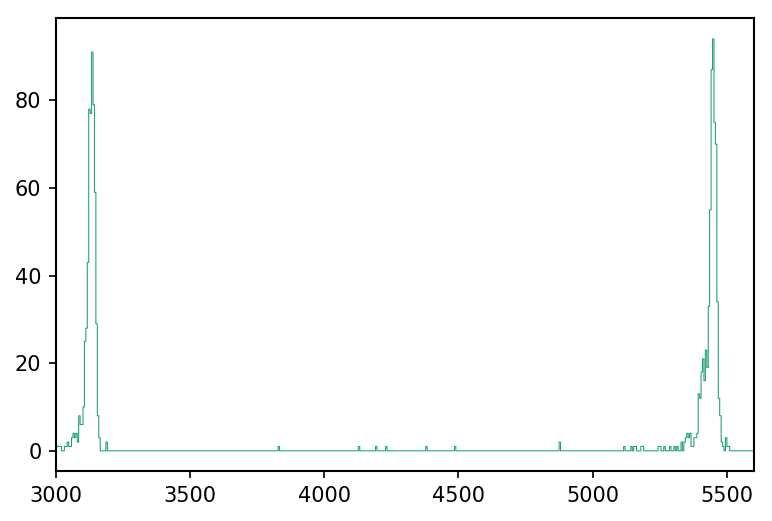

In [13]:
plt.plot(energy, target_det.counts, lw=0.5, drawstyle='steps-mid')
plt.xlim((3000, 5600))
plt.show()

Visually, it looks like there is a small offset left for both peaks, so let's fit them! We'll just do a single peak fit since our 5442.8 keV line isn't coming through.

[   92.94875281   -11.61385576  3133.44284088   -13.71204223]


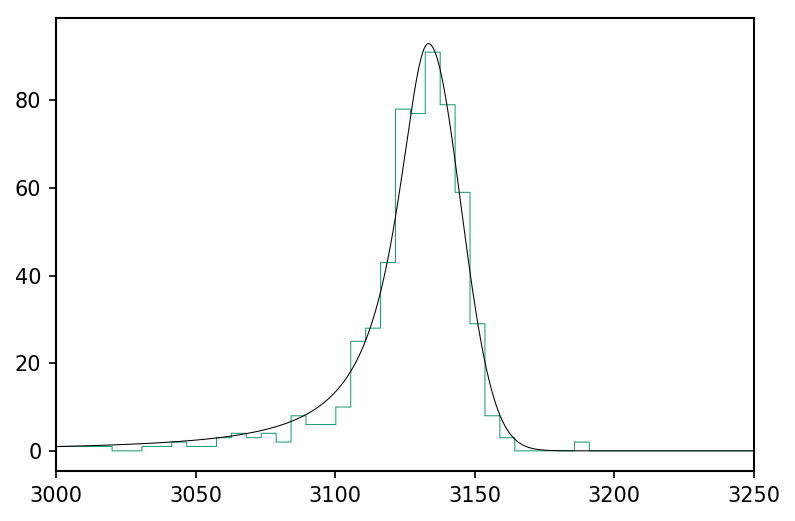

[   93.01911001   -11.46555953  5449.78942521   -13.873622  ]


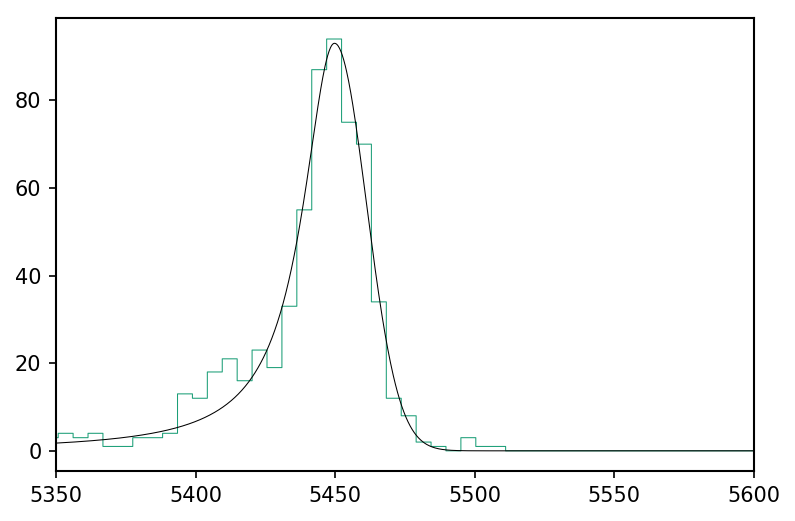

In [14]:
p_gd_t = [100, 10, 3180, 10]
p_am_t = [100, 10, 5485, 2]

par_gd_t, _ = curve_fit(gd_peak, energy[500:650], target_det.counts[500:650], p0=p_gd_t)
par_am_t, _ = curve_fit(gd_peak, energy[950:1050], target_det.counts[950:1050], p0=p_am_t)

print(par_gd_t)
e_smooth_1 = np.linspace(3000, 3250, 1000)
plt.plot(energy, target_det.counts, lw=0.5, drawstyle='steps-mid')
plt.plot(e_smooth_1, gd_peak(e_smooth_1, *par_gd_t), 'k-', lw=0.5)
plt.xlim((3000, 3250))
plt.show()

print(par_am_t)
e_smooth_2 = np.linspace(5350, 5600, 1000)
plt.plot(energy, target_det.counts, lw=0.5, drawstyle='steps-mid')
plt.plot(e_smooth_2, gd_peak(e_smooth_2, *par_am_t), 'k-', lw=0.5)
plt.xlim((5350, 5600))
plt.show()

Our two peaks are located at 3133.44308174 and 5449.78923914 keV, a loss of 49.247 keV for the Gd alpha and 35.771 for the Am alpha. Each peak should have a slightly different energy loss since they are different energies, which we clearly see. Using these two peaks, we can figure out out thicknesses by using SRIM data.

In [15]:
# energy in keV, range in cm
def load_srim(filename):
    data = np.loadtxt(filename, skiprows=8, usecols=[0, 4])
    turnovers = data.argmax(axis=0)
    data[turnovers[0] + 1:, :][:, 0] *= 1000
    data[turnovers[1] + 1:, :][:, 1] /= 1e4
    data[:turnovers[1] + 1, :][:, 1] /= 1e8
    return data

h_al = load_srim('../SRIM_Hydrogen_Aluminium.txt')
he_al = load_srim('../SRIM_Helium_Aluminium.txt')

In [16]:
from scipy import interpolate

h_spline = interpolate.splrep(h_al[:, 0], h_al[:, 1], s=0)
he_spline = interpolate.splrep(he_al[:, 0], he_al[:, 1], s=0)

In [17]:
interpolate.splev(1326, h_spline, der=0)

array(0.0021911777563649788)

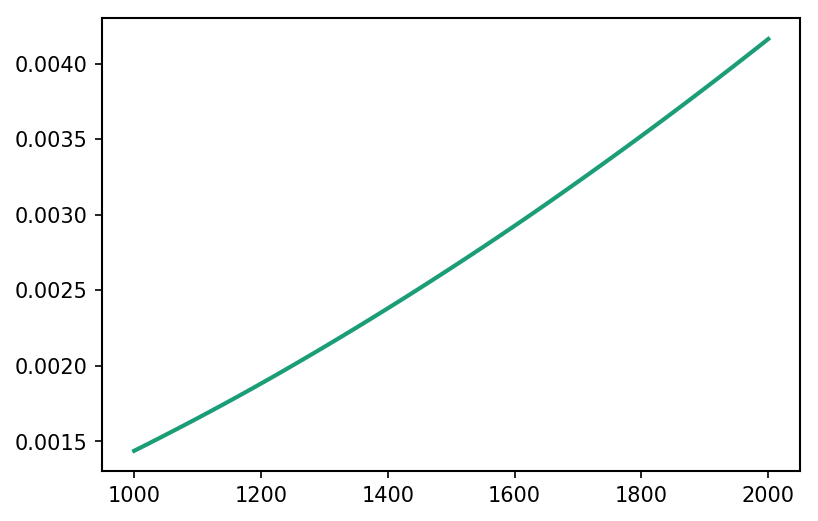

In [18]:
x = np.linspace(1000, 2000)
plt.plot(x, interpolate.splev(x, h_spline, der=0))
plt.show()

Instead of following what Manoel did, let's do it more rigorously. We know the entrance and exit energies of the alphas from the 241Am/148Gd calibration runs, so we can integrate our energy loss between those two energies and, knowing the total energy loss, we can find the thickness in $\mu$g/cm$^2$ directly.

I'll just use my alpha loss data.

In [19]:
he_al = np.loadtxt('../SRIM_Helium_Aluminium.txt', skiprows=8, usecols=[0, 2, 3])
he_al[he_al.argmax(axis=0)[0] + 1:, :][:, 0] *= 1000
he_energy = he_al[:, 0]
he_loss = he_al[:, 1] + he_al[:, 2]

losses = np.array([49.247, 35.771])  # keV
start_energy = [3182.69, 5485.56]
stopping_energy = [3133.44308174, 5449.78923914]

print(he_energy[:5], he_loss[:5], sep='\n')

[ 10.  11.  12.  13.  14.]
[ 0.29896  0.31148  0.32348  0.33524  0.34673]


In [20]:
he_loss_spline = interpolate.splrep(he_energy, he_loss, s=0)

In [21]:
loss_values_start = [interpolate.splev(e, he_loss_spline, der=0)
                     for e in start_energy]
loss_values_stop = [interpolate.splev(e, he_loss_spline, der=0)
                    for e in stopping_energy]

gd_loss = np.array([loss_values_start[0], loss_values_stop[0]])
am_loss = np.array([loss_values_start[1], loss_values_stop[1]])
print(gd_loss, am_loss, sep='\n')  # keV / ug/cm**2

[ 0.78256335  0.78916034]
[ 0.57013052  0.57242961]


In [22]:
thicknesses = np.array([losses[0] / gd_loss, losses[1] / am_loss]).flatten()
thicknesses

array([ 62.93036873,  62.40430171,  62.74177313,  62.48977924])

In [23]:
thicknesses.mean(), thicknesses.std(ddof=1)

(62.641555704099943, 0.23998753699074529)

OK, but really we shouldn't just be using the values of the energy loss at just the start and end, despite how close they are to each other. We should be integrating along the dE/dx curve for a thickness equal to our target thickness to determine the total energy loss. Let's try doing that now.

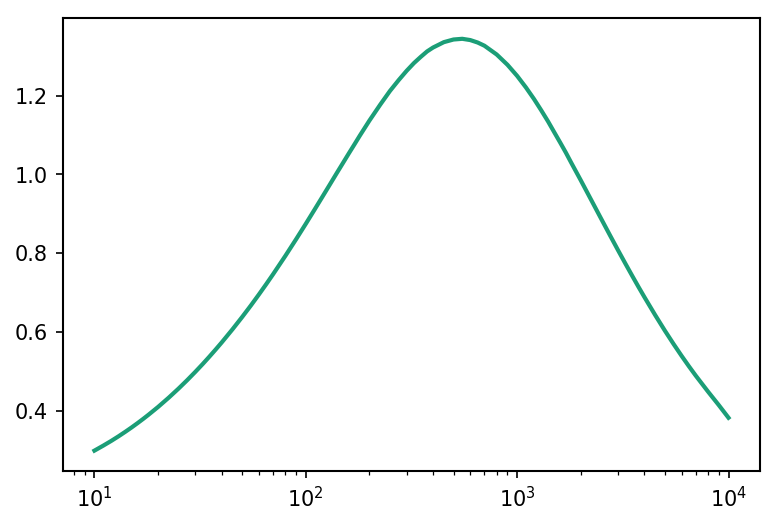

In [24]:
plt.semilogx(he_energy, he_loss)
plt.show()

In [25]:
he_thick = 1 / he_loss  # ug/cm**2 / keV
he_thick

array([ 3.34492909,  3.210479  ,  3.09138123,  2.9829376 ,  2.88408848,
        2.79454505,  2.71186441,  2.63608805,  2.56587894,  2.44081035,
        2.30616669,  2.1914446 ,  2.09226907,  2.00541462,  1.92904956,
        1.86060358,  1.79943498,  1.74431788,  1.64820675,  1.56744726,
        1.4985539 ,  1.43866262,  1.38625116,  1.33985396,  1.26130444,
        1.19713167,  1.14377216,  1.09855463,  1.05991037,  1.02654228,
        0.99733214,  0.97195048,  0.94922861,  0.92923676,  0.91087208,
        0.88003379,  0.84978156,  0.825545  ,  0.80714159,  0.79200769,
        0.77982864,  0.77036498,  0.76227181,  0.75661623,  0.7488707 ,
        0.74511651,  0.74413399,  0.74590628,  0.74935387,  0.7539562 ,
        0.7668153 ,  0.78253323,  0.80016515,  0.81926317,  0.83928033,
        0.86028906,  0.88158855,  0.90396134,  0.92577506,  0.94776219,
        0.97081252,  1.01535841,  1.07160324,  1.12751584,  1.18309229,
        1.23809985,  1.29241797,  1.34625052,  1.39964085,  1.45

In [26]:
he_thick_spline = interpolate.splrep(he_energy, he_thick, s=0)
gd_thickness = interpolate.splint(*gd_loss[::-1], he_thick_spline)
am_thickness = interpolate.splint(*am_loss[::-1], he_thick_spline)
new_thickness = np.array([gd_thickness, am_thickness])

new_thickness.mean(), new_thickness.std(ddof=1)

(41.996408246977381, 0.97240496750313199)

This isn't what I want... I want the derivative of the energy loss curve with respect to energy integrated between my two energy points to give me a total energy loss per $\mu$g/cm$^2$, which I can then use to find the thickness knowing already what my total energy loss is.

In [27]:
dE_spline_data = interpolate.splev(he_energy, he_loss_spline, der=1)
dE_spline = interpolate.splrep(he_energy, dE_spline_data, s=0)
gd_thickness = interpolate.splint(start_energy[0], stopping_energy[0], dE_spline)
am_thickness = interpolate.splint(start_energy[0], stopping_energy[0], dE_spline)
new_thickness = np.array([gd_thickness, am_thickness])

new_thickness  # keV / ug/cm**2 ... ??

array([ 0.006595,  0.006595])

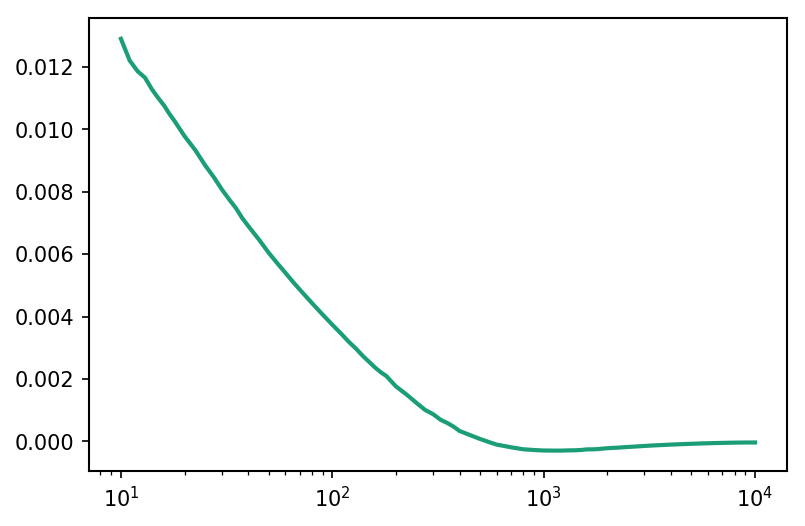

In [28]:
plt.semilogx(he_energy, dE_spline_data)
plt.show()

In [29]:
losses / new_thickness

array([ 7467.32286625,  5423.95691613])

Update
------

After speaking with Manoel about this, he says that using the ranges is the best way, since they account for energy loss through the target already, which is what I have been struggling to do.

In [30]:
# energy in keV, range in cm
def load_srim(filename):
    data = np.loadtxt(filename, skiprows=8, usecols=[0, 4])
    turnovers = data.argmax(axis=0)
    data[turnovers[0] + 1:, :][:, 0] *= 1000
    data[turnovers[1] + 1:, :][:, 1] /= 1e4
    data[:turnovers[1] + 1, :][:, 1] /= 1e8
    return data

he_al = load_srim('../SRIM_Helium_Aluminium.txt')
he_spline = interpolate.splrep(he_al[:, 0], he_al[:, 1], s=0)

In [31]:
gd_energy = np.array([3182.69, par_gd_t[2]])
am_energy = np.array([5485.56, par_am_t[2]])

range_gd = interpolate.splev(gd_energy, he_spline, der=0)
range_am = interpolate.splev(am_energy, he_spline, der=0)
print(range_gd, range_am, sep='\n')

[ 0.001153    0.00112983]
[ 0.00244563  0.00242251]


In [32]:
p_al = 2700000

ranges = np.vstack([range_gd, range_am])
start, stop = ranges.T
range_diff = start - stop
ug = range_diff * p_al

ug, ug.mean(), ug.std(ddof=0)

(array([ 62.5546174 ,  62.44640423]), 62.500510814759934, 0.054106583483807924)